In [3]:
import tensorflow as tf
import winsound
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

In [37]:
np.random.seed = 42
Img_width = 128
Img_height = 128
Img_depth = 3

In [11]:
train_location = r"C:\Users\karth\All about ML\Unet\stage1_train"

x_train = []
y_train = []
count = 0

for root,dir,files in os.walk(train_location):

    if(os.path.basename(root)=='images'):
        image_path = os.path.join(root, files[0])
        original_image = cv2.imread(image_path)
        resized_img = cv2.resize(original_image,(Img_width,Img_height))

        print(f"{count}",end='\r')
        count = count+1
        x_train.append(resized_img)

    if(os.path.basename(root)=='masks'):
        added_mask = np.zeros((Img_width,Img_height),dtype = np.bool_)
        for file in files:
            mask_path = os.path.join(root, file)
            original_mask = cv2.imread(mask_path)
            resized_mask = cv2.resize(original_mask,(Img_width,Img_height))
            gray_mask = cv2.cvtColor(resized_mask, cv2.COLOR_BGR2GRAY)
            added_mask = added_mask+gray_mask
            bool_added_mask = np.array(added_mask,dtype=np.bool_)

        print(f"{count}",end='\r')
        count = count+1
        y_train.append(bool_added_mask)

x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1],y_train.shape[2],1))

winsound.Beep(1000,2000)

In [28]:
print(x_train.shape)
print(y_train.shape)


(670, 128, 128, 3)
(670, 128, 128, 1)


In [13]:
# for test images
test_location = r"C:\Users\karth\All about ML\Unet\stage1_test"
x_test = []
count = 0

for root,dir,files in os.walk(test_location):

    if(os.path.basename(root)=='images'):
        image_path = os.path.join(root, files[0])
        original_image = cv2.imread(image_path)
        resized_img = cv2.resize(original_image,(Img_width,Img_height))

        print(f"{count}",end='\r')
        count = count+1
        x_test.append(resized_img)

x_test = np.array(x_test)
winsound.Beep(1000,2000)

In [14]:
x_test.shape

(65, 128, 128, 3)

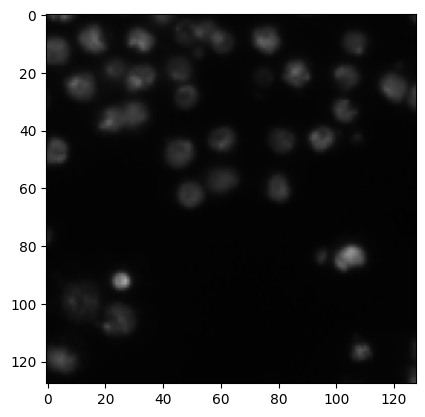

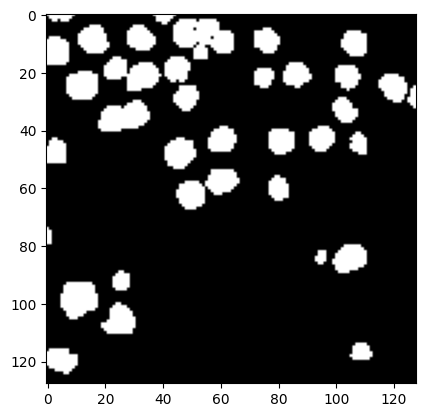

In [33]:
index = 100
plt.imshow(x_train[index])
plt.show()
plt.imshow(np.squeeze(y_train[index]),cmap='gray')
plt.show()

### model - UNET

In [34]:
inputs = tf.keras.layers.Input((Img_width,Img_height,Img_depth))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

## contraction or encoding
# 128,128,3
c1 = tf.keras.layers.Conv2D(filters=16,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(filters=16,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

# 64,64,16
c2= tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(p1)
c2= tf.keras.layers.Dropout(0.1)(c2)
c2= tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

# 32,32,32
c3 = tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

# 16,16,64
c4 = tf.keras.layers.Conv2D(filters=128,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(filters=128,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

# 8,8,128
c5 = tf.keras.layers.Conv2D(filters=256,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(filters=256,kernel_size = (3,3) , activation='relu',kernel_initializer="he_normal",padding="same")(c5)
# 8,8,256


## decoding or expansion
u6 = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding= 'same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(c6)

# 16,16,128
u7 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding= 'same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(c7)

# 32,32,64
u8 = tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding= 'same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(c8)

# 64,64,32
u9 = tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding= 'same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding= 'same')(c9)

# 128,128,8
outputs = tf.keras.layers.Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid')(c9)



##### model parameters = no of weights + biases

In [35]:
a = 3*9*16+16
a

448

In [36]:
model = tf.keras.Model(inputs=[inputs],outputs = [outputs])
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

### in case of working with filters/ CNN's
number of parameters = number of feature maps* kernel_size * number_of_filters + number of filters(bias)

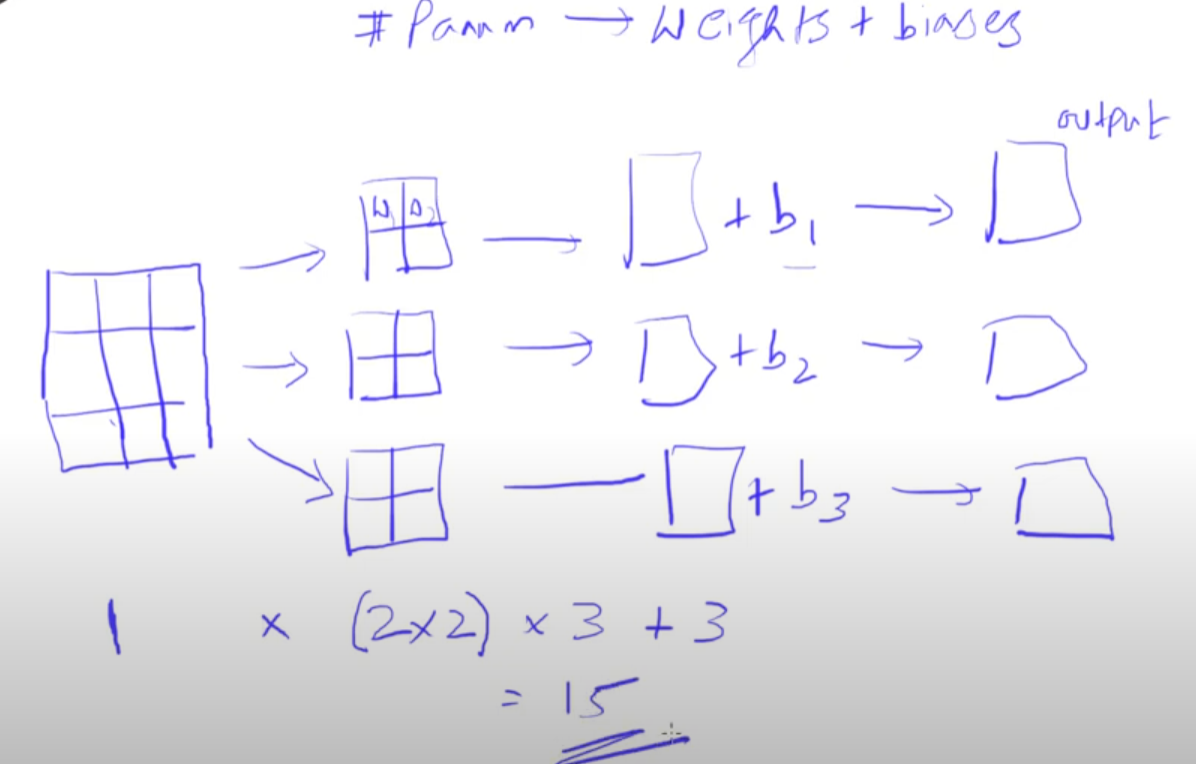

for example first for block c1

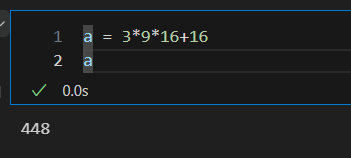


In [40]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras',verbose=1,save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer,
]

history = model.fit(x_train,y_train,validation_split=0.1,batch_size=16,epochs=25,callbacks=callbacks)

Epoch 1/25


c:\Users\karth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.7956 - loss: 0.5815
Epoch 1: val_loss improved from inf to 0.26231, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 646ms/step - accuracy: 0.7965 - loss: 0.5790 - val_accuracy: 0.8572 - val_loss: 0.2623
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8533 - loss: 0.2657
Epoch 2: val_loss improved from 0.26231 to 0.18625, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.8535 - loss: 0.2651 - val_accuracy: 0.8785 - val_loss: 0.1863
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8822 - loss: 0.2019
Epoch 3: val_loss improved from 0.18625 to 0.15582, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 720ms/step - accuracy: 0.8827 - loss: 0.2015 - val_accuracy: 0.9431 - val_loss: 0.1558
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9411 - loss: 0.1556
Epoch 4: val_loss improved from 0.15582 to 0

In [41]:
winsound.Beep(1000,1000)

## testing

In [42]:
y_test_preds = model.predict(x_test)

c:\Users\karth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step


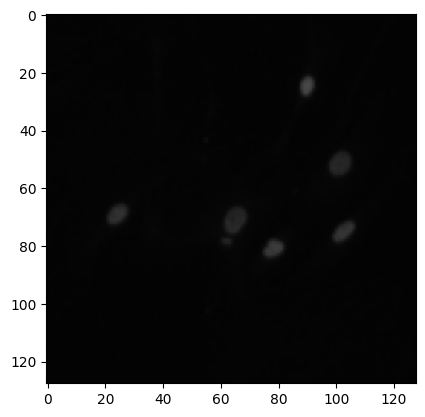

<function matplotlib.pyplot.show(close=None, block=None)>

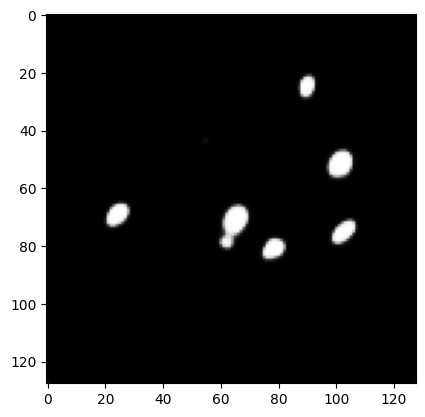

In [51]:
index = 0
plt.imshow(x_test[index])
plt.show()

plt.imshow(y_test_preds[index],cmap='gray')
plt.show

In [58]:
winsound.Beep(1000,2000)

### tensorboard
tensorboard --logdir=logs

use this in command prompt(open command prompt in this folder)

then we will get a link where we can see the results